In [1]:
# Flight Ticket Price Prediction.ipynb
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm

print("Successfully Imported.")

start_time = time.time()


Successfully Imported.


In [2]:
# Load the dataset
file_path = 'flights_data.csv'
flights_data = pd.read_csv(file_path)
print(f"Dataset loaded in {time.time() - start_time:.2f} seconds.")
print(flights_data)

# Convert date columns to datetime format
flights_data['depart_date'] = pd.to_datetime(flights_data['depart_date'], format='%d/%m/%Y')
flights_data['return_date'] = pd.to_datetime(flights_data['return_date'], format='%d/%m/%Y')
print(f"Date columns converted in {time.time() - start_time:.2f} seconds.")

Dataset loaded in 0.88 seconds.
       source_city destination_city   value return_date  number_of_changes  \
0              TYO              LON  112807   25/5/2024                  1   
1              TYO              LON  113896   26/5/2024                  1   
2              TYO              LON  227248   25/5/2024                  0   
3              TYO              LON   91008   21/5/2024                  2   
4              TYO              LON  144323   23/5/2024                  2   
...            ...              ...     ...         ...                ...   
708778         SEL              TLV   76727   22/2/2025                  2   
708779         SEL              TLV  106727   18/3/2025                  1   
708780         SEL              TLV  103636   18/3/2025                  2   
708781         SEL              TLV   80000   11/5/2025                  1   
708782         SEL              TLV   85636   11/5/2025                  2   

       gate depart_date  durati

In [3]:
# Drop the 'gate' column as it has mostly null values
flights_data = flights_data.drop(columns=['gate'])

# Remove any outliers or incorrect data entries
flights_data = flights_data[(flights_data['value'] > 0) & (flights_data['duration'] > 0)]

# Remove rows with extreme outliers in the 'value' column
flights_data = flights_data[flights_data['value'] < flights_data['value'].quantile(0.99)]

# Fill missing values in 'number_of_changes' with the median
flights_data['number_of_changes'].fillna(flights_data['number_of_changes'].median(), inplace=True)
print(f"Data cleaned in {time.time() - start_time:.2f} seconds.")

# Convert categorical time columns to numeric (using one-hot encoding)
flights_data = pd.get_dummies(flights_data, columns=['departure_time', 'arrival_time'], drop_first=True)

# Convert categorical city columns to numeric (using one-hot encoding)
flights_data = pd.get_dummies(flights_data, columns=['source_city', 'destination_city'], drop_first=True)
print(f"Categorical columns converted in {time.time() - start_time:.2f} seconds.")

Data cleaned in 1.35 seconds.
Categorical columns converted in 1.93 seconds.


In [4]:
# Extract day, month, and year from 'depart_date' for better feature representation
flights_data['depart_day'] = flights_data['depart_date'].dt.day
flights_data['depart_month'] = flights_data['depart_date'].dt.month
flights_data['depart_year'] = flights_data['depart_date'].dt.year
flights_data['depart_day_of_week'] = flights_data['depart_date'].dt.dayofweek

# Drop the original 'depart_date' and 'return_date' columns as they are no longer needed
flights_data = flights_data.drop(columns=['depart_date', 'return_date'])
print(f"Date columns dropped and new features extracted in {time.time() - start_time:.2f} seconds.")

Date columns dropped and new features extracted in 2.12 seconds.


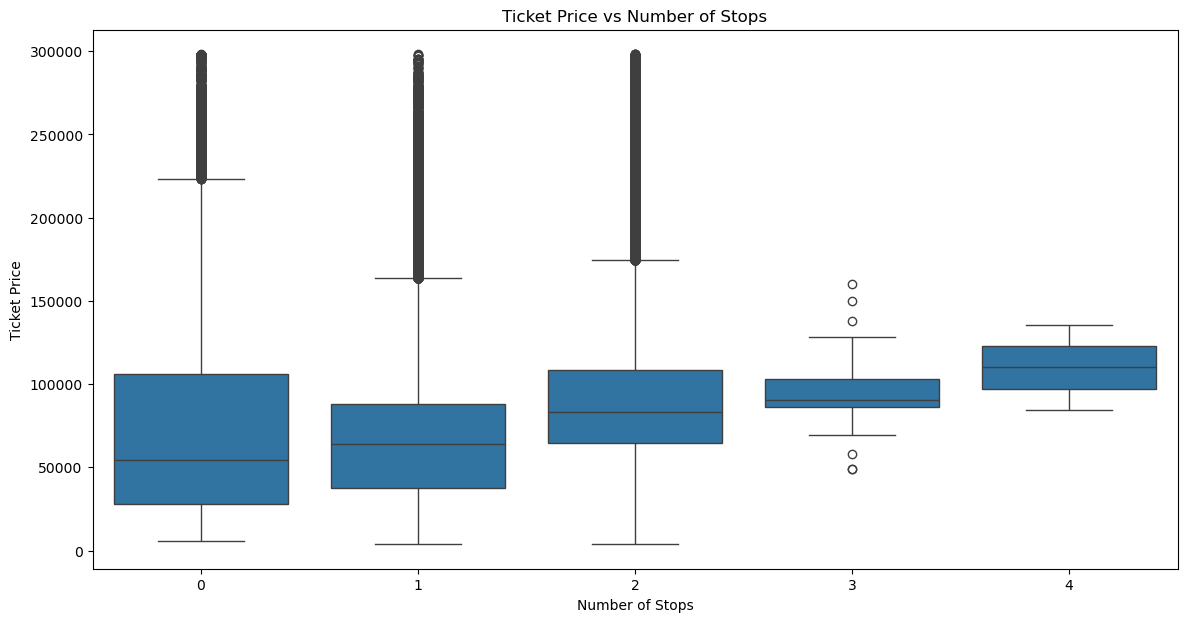

In [17]:
# Ticket Price vs Number of Stops
plt.figure(figsize=(14, 7))
sns.boxplot(x='number_of_changes', y='value', data=flights_data)
plt.title('Ticket Price vs Number of Stops')
plt.xlabel('Number of Stops')
plt.ylabel('Ticket Price')
plt.show()



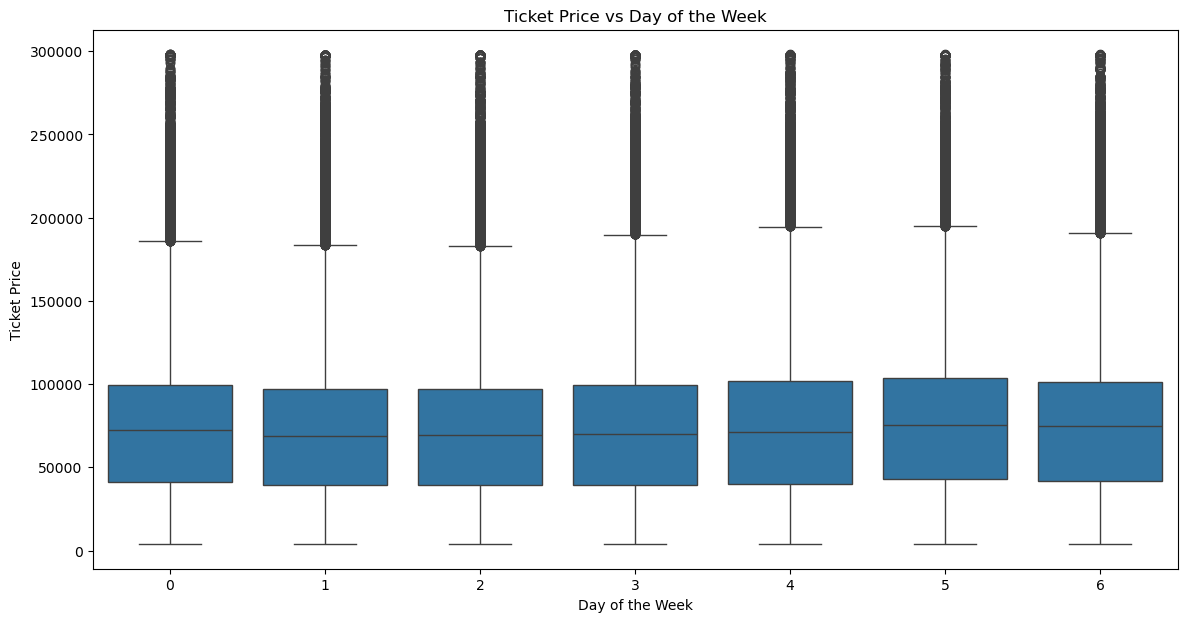

In [18]:
# Ticket Price vs Day of the Week
plt.figure(figsize=(14, 7))
sns.boxplot(x='depart_day_of_week', y='value', data=flights_data)
plt.title('Ticket Price vs Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Ticket Price')
plt.show()



In [ ]:
# Visualize the correlation with the target variable
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Correlation of Features with Ticket Price')
plt.xlabel('Features')
plt.ylabel('Correlation with Ticket Price')
plt.show()

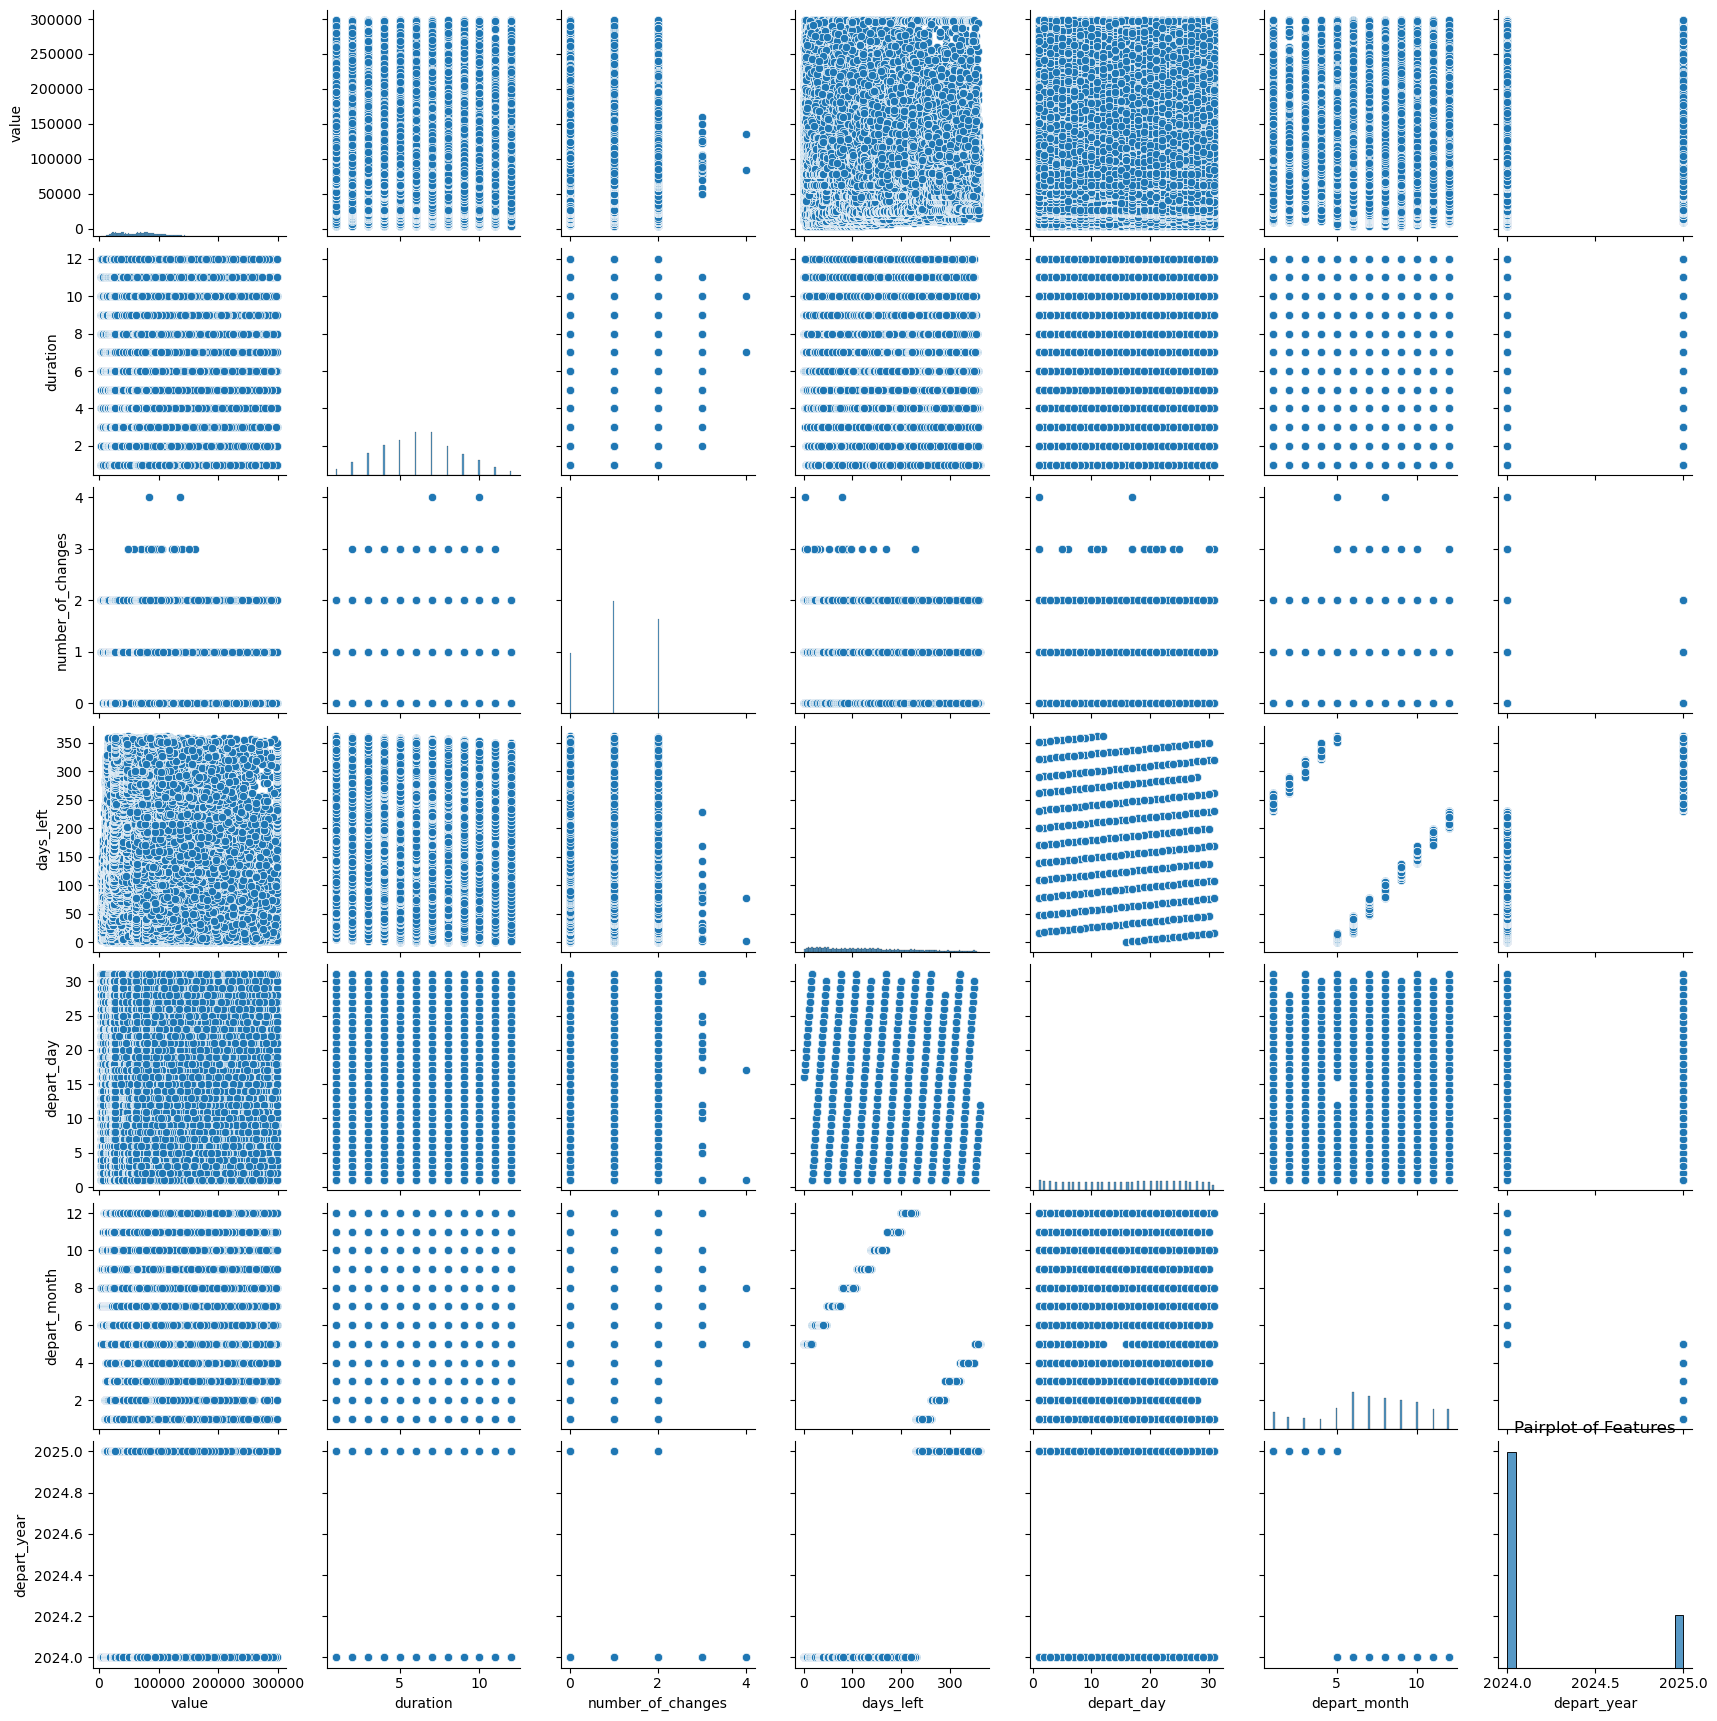

In [20]:
# Pairplot
sns.pairplot(flights_data[['value', 'duration', 'number_of_changes', 'days_left', 'depart_day', 'depart_month', 'depart_year']])
plt.title('Pairplot of Features')
plt.show()

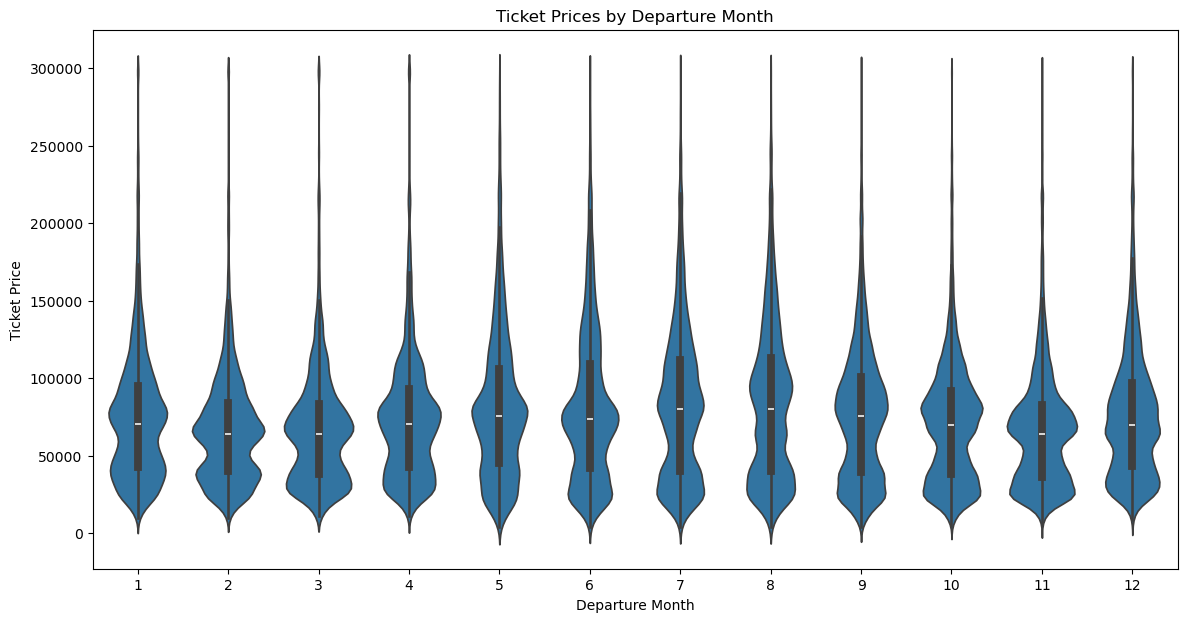

In [21]:
# Violin Plot for Ticket Prices by Departure Month
plt.figure(figsize=(14, 7))
sns.violinplot(x='depart_month', y='value', data=flights_data)
plt.title('Ticket Prices by Departure Month')
plt.xlabel('Departure Month')
plt.ylabel('Ticket Price')
plt.show()



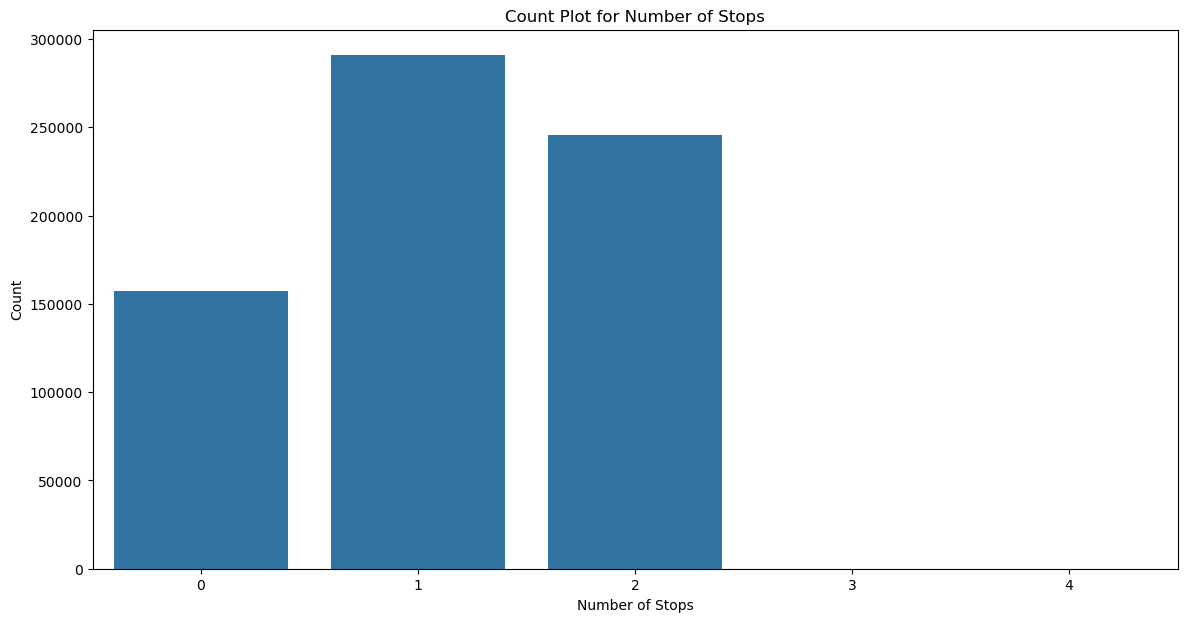

In [22]:
# Count Plot for Number of Stops
plt.figure(figsize=(14, 7))
sns.countplot(x='number_of_changes', data=flights_data)
plt.title('Count Plot for Number of Stops')
plt.xlabel('Number of Stops')
plt.ylabel('Count')
plt.show()



In [24]:
# Optionally reduce dataset size for faster processing
flights_data = flights_data.sample(frac=0.2, random_state=42)
print(f"Dataset reduced in {time.time() - start_time:.2f} seconds.")

# Define the target variable and features
X = flights_data.drop(columns=['value'])
y = flights_data['value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data split into training and testing sets in {time.time() - start_time:.2f} seconds.")



Dataset reduced in 238.56 seconds.
Data split into training and testing sets in 238.64 seconds.


In [25]:
# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, None]
}

print("Starting Random Forest Grid Search...")
rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)
print(f"Random Forest Grid Search completed in {time.time() - start_time:.2f} seconds.")



Starting Random Forest Grid Search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Random Forest Grid Search completed in 748.11 seconds.


In [26]:
# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6]
}

print("Starting XGBoost Grid Search...")
xgb_grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=xgb_param_grid, cv=3, n_jobs=-1, verbose=2)
xgb_grid_search.fit(X_train, y_train)
print(f"XGBoost Grid Search completed in {time.time() - start_time:.2f} seconds.")



Starting XGBoost Grid Search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
XGBoost Grid Search completed in 756.41 seconds.


In [27]:
# Initialize and train the linear regression model
print("Training Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print(f"Linear Regression model trained in {time.time() - start_time:.2f} seconds.")



Training Linear Regression model...
Linear Regression model trained in 756.95 seconds.


In [28]:
# Train the best Random Forest model
print("Training best Random Forest model...")
rf_model = rf_grid_search.best_estimator_
rf_model.fit(X_train, y_train)
print(f"Best Random Forest model trained in {time.time() - start_time:.2f} seconds.")



Training best Random Forest model...
Best Random Forest model trained in 1035.14 seconds.


In [29]:
# Train the best XGBoost model
print("Training best XGBoost model...")
xgb_model = xgb_grid_search.best_estimator_
xgb_model.fit(X_train, y_train)
print(f"Best XGBoost model trained in {time.time() - start_time:.2f} seconds.")



Training best XGBoost model...
Best XGBoost model trained in 1036.81 seconds.


In [30]:
# Predict the prices on the test set using all models
print("Predicting prices using all models...")
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
print(f"Price prediction completed in {time.time() - start_time:.2f} seconds.")



Predicting prices using all models...
Price prediction completed in 1039.01 seconds.


In [31]:
# Evaluate the models and store the results
evaluation_results = []

def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    evaluation_results.append({
        "Model": model_name,
        "Mean Absolute Error": mae,
        "Root Mean Squared Error": rmse,
        "R-squared": r2
    })
    print(f"Model: {model_name}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R-squared: {r2}")
    print("-" * 30)

# Evaluate Linear Regression
evaluate_model(y_test, y_pred_lr, "Linear Regression")

# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
evaluate_model(y_test, y_pred_xgb, "XGBoost")

print(f"Model evaluation completed in {time.time() - start_time:.2f} seconds.")



Model: Linear Regression
Mean Absolute Error: 20204.1834809605
Root Mean Squared Error: 29835.427157357888
R-squared: 0.5607422679160494
------------------------------
Model: Random Forest
Mean Absolute Error: 9778.821990312816
Root Mean Squared Error: 18012.205068796568
R-squared: 0.8399009848629262
------------------------------
Model: XGBoost
Mean Absolute Error: 12938.906039123292
Root Mean Squared Error: 21022.792555472857
R-squared: 0.7819100240603766
------------------------------
Model evaluation completed in 1039.06 seconds.


In [32]:
# Convert the evaluation results to a DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

# Visualization of Evaluation Results
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

Text(0, 0.5, 'Mean Absolute Error')

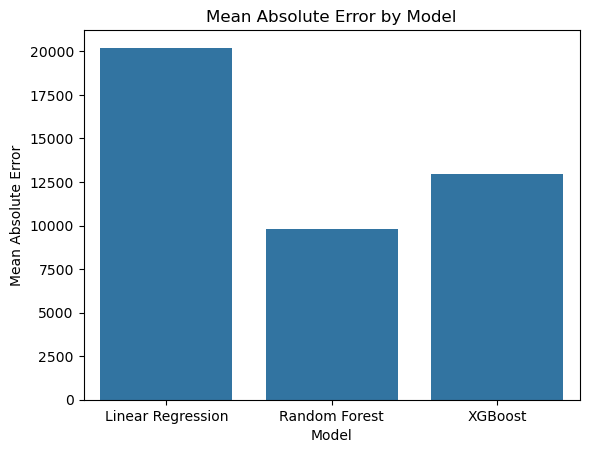

In [38]:
# Mean Absolute Error
sns.barplot(x='Model', y='Mean Absolute Error', data=evaluation_df)
plt.title('Mean Absolute Error by Model')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error')



Text(0, 0.5, 'Root Mean Squared Error')

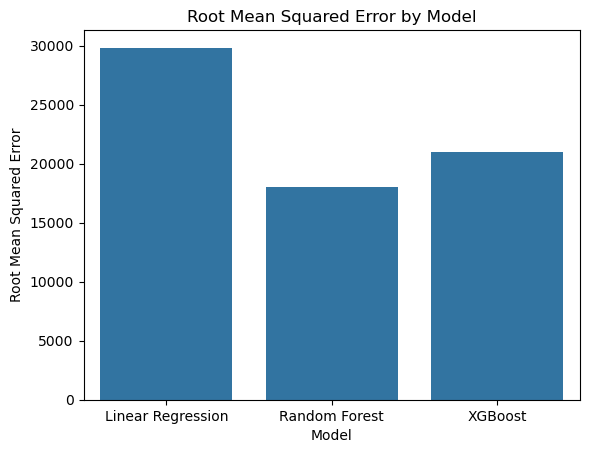

In [39]:
# Root Mean Squared Error
sns.barplot(x='Model', y='Root Mean Squared Error', data=evaluation_df)
plt.title('Root Mean Squared Error by Model')
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error')



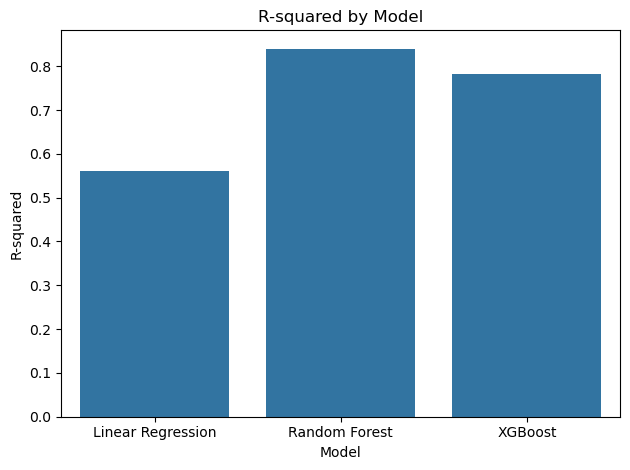

--- 1148.336050271988 seconds ---


In [40]:
# R-squared
sns.barplot(x='Model', y='R-squared', data=evaluation_df)
plt.title('R-squared by Model')
plt.xlabel('Model')
plt.ylabel('R-squared')

print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\skymi\AppData\Local\Temp\ipykernel_29664\3403774114.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='R-squared', data=evaluation_df, palette='Set3')


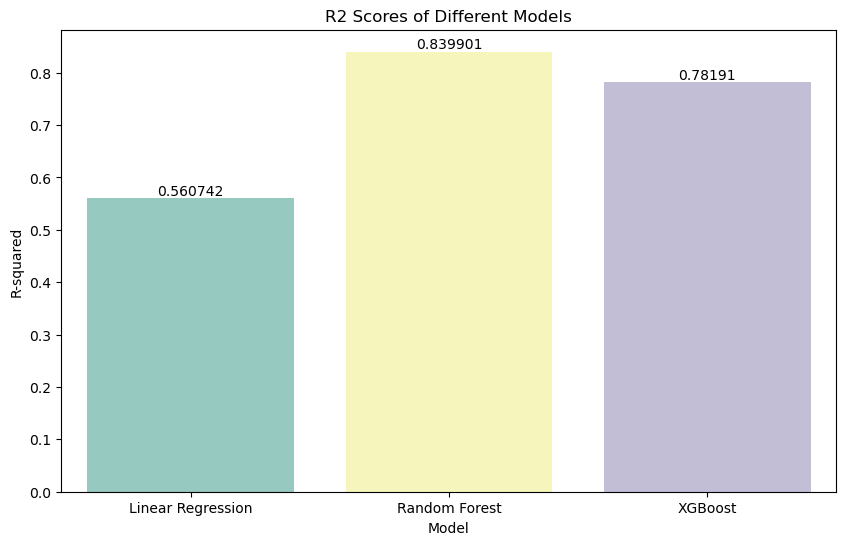

In [42]:
# Visualizing the results
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='R-squared', data=evaluation_df, palette='Set3')
for container in ax.containers:
    ax.bar_label(container)
plt.title('R2 Scores of Different Models')
plt.show()

In [43]:
import joblib

joblib.dump(rf_model, 'rf_model.joblib')

print("Save Successfully!")

Save Successfully!
